The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


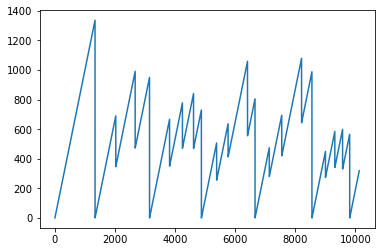

In [5]:
from Delta_Cutoffs import *
%load_ext autoreload
%autoreload 2

ASSET = 'sETH'+'new'

updated = pd.read_csv('{}.csv'.format(ASSET)) # import the new sETH data

updated = updated.drop(0)
updated = updated.reset_index();
updated = updated[updated.expiry > 1635235200]  #COMMENT OUT FOR SOL
#


starting_sUSD_ETH= [10.66*1000000, 24.83*1000000, 30.0*1000000, 19.7*1000000, 27.4*1000000, 21.2*1000000]
starting_sUSD_BTC = [10.58*1000000, 24.73*1000000,28.36*1000000, 18.54*1000000, 10.19*1000000, 8.28*1000000, 7.04*1000000]
starting_sUSD_LINK = [2.45*1000000, 5.22*1000000, 4.25*1000000, 4.17*1000000, 3.33*1000000, 2.76*1000000, 1.5*1000000] 

starting_sUSD_SOL = [304100, 4.98*1000000]


from DECKHedgeFunctions import *

starting_sUSDs = {"sETHnew": starting_sUSD_ETH, "sBTCnew": starting_sUSD_BTC, "sLINKnew": starting_sUSD_LINK, 'sSOLnew': starting_sUSD_SOL}

all_final_spots = {"sETHnew": final_spots_ETH, "sBTCnew": final_spots_BTC, "sLINKnew": final_spots_LINK, 'sSOLnew': final_spots_SOL}

starting_sUSD = starting_sUSDs[ASSET]
final_spots = all_final_spots[ASSET]

df_check = Checker(updated.iloc[:])
check_arr = np.array(df_check)
round_starts = np.where(check_arr == 1)[0]
round_times = [updated.iloc[round_starts[i]].expiry for i in range(0,len(round_starts))]


df_cum = tack_on_collat(updated)

edges = []
for i in range(0,len(round_starts)-1):
    df_cum_dup = df_cum.copy()
    df_round_choose = df_cum_dup.iloc[round_starts[i]:round_starts[i+1]]
    edge = df_round_choose.apply(lambda x: true_cost(x), axis = 1).sum()
    edges.append(edge)

#print(starting_sUSD)
#print(round_times)

df_check = Checker(updated.iloc[:])
plt.plot(df_check)

pnls_real_ETH  = [-2.074,.001,-.626,-.7,.36,2.55]
pnls_real_BTC = [-0.586, -0.1164, -0.2137, -0.3414, 0.667, 1.185]
pnls_real_LINK = [-1.906, -2.48, 2.846, -4.5, 0.834, 0.0713]
pnls_real_SOL = [+1.038, +0.1855]
pnls_reals = {"sETHnew": pnls_real_ETH, "sBTCnew": pnls_real_BTC, "sLINKnew": pnls_real_LINK, 'sSOLnew': pnls_real_SOL}
pnls_real = pnls_reals[str(ASSET)]

0
1
2
3
4
5


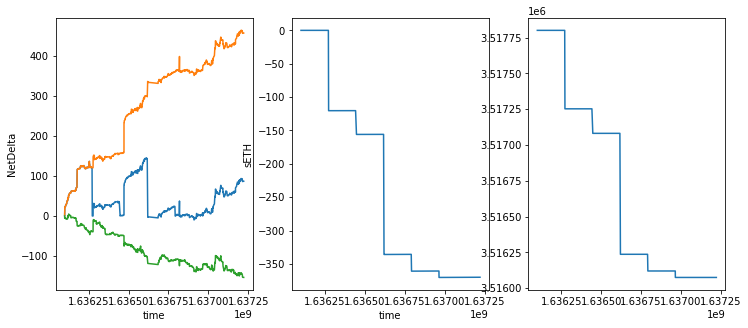

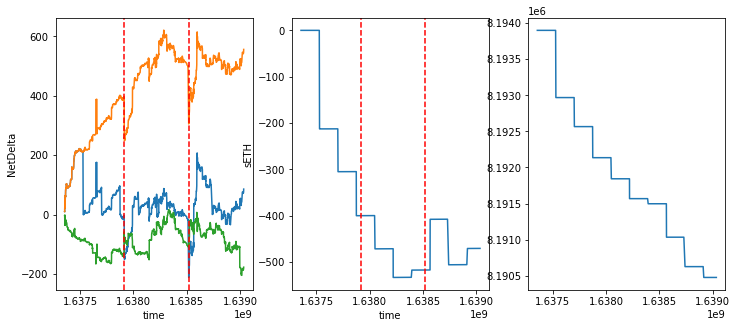

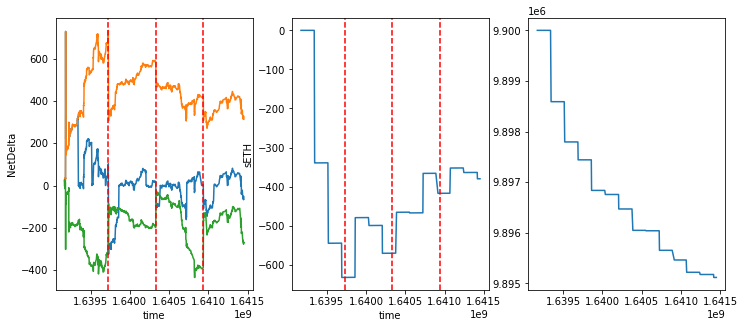

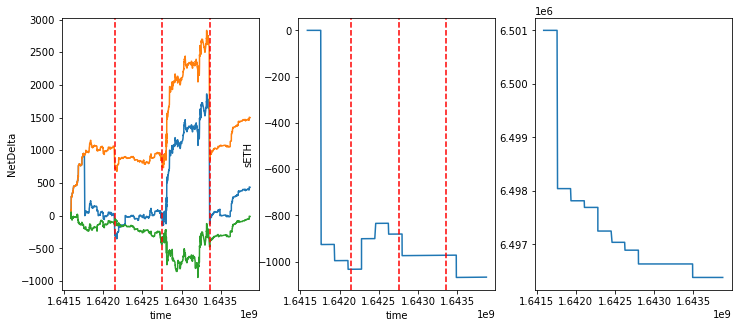

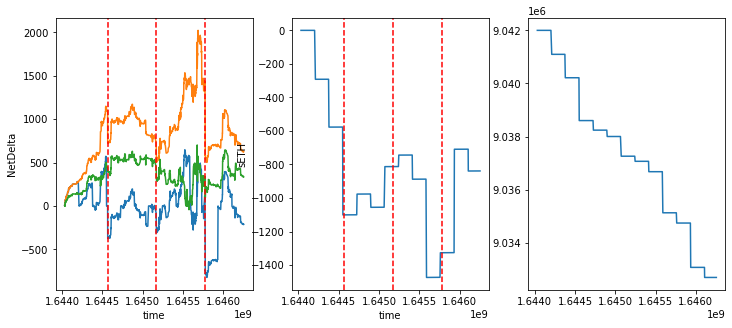

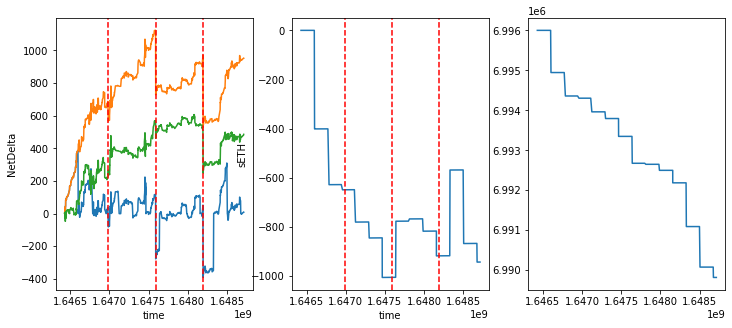

In [6]:
from DECKHedgeFunctions import *

hedge_freq = 48

data_pnl_percent_hedge = []
data_pnl_hedge = []
data_uh = []
data_percent_uh = []

hedge_fees = [];

short_rate_fees = [];

prems = [];

optionPNL = [];

collatPNL = [];

hedgePNL = [];

HEDGE_SHIFT = 0;

AMM_collat_fees = [];
for i in range(0,len(pnls_real)):
    print(i)
    #pnl = PNL_total(updated, round_starts, i, final_spots)
    prem, opt_val, collat_pnl = PNL_total(updated, round_starts, i, final_spots)

    pnl = prem + opt_val + collat_pnl #collat_pnl includes the fees paid to buy/sell the underlying on SNX
    
    df_with_fees = fee_df(updated, i, round_starts)
    
    AMM_collat_fee = df_with_fees['AMM collat fee'].sum()
      
    fees, ETHs, hedge_pnl, short_rate_fee = HedgeVisualize(hedge_freq, i, round_starts,starting_sUSD, df_cum,'plot', final_spots, HEDGE_SHIFT)
    
    total_pnl_hedge = pnl - np.sum(fees) - abs(short_rate_fee) + hedge_pnl
    
    percent_pnl_hedge = 100* total_pnl_hedge / starting_sUSD[i]
    
    total_pnl_UH = pnl
    
    percent_pnl_UH = 100* pnl / starting_sUSD[i]
    
    data_pnl_percent_hedge.append(percent_pnl_hedge)
    data_pnl_hedge.append(total_pnl_hedge)
    
    data_uh.append(total_pnl_UH)
    data_percent_uh.append(percent_pnl_UH)
    
    prems.append(prem)
    optionPNL.append(opt_val)
    collatPNL.append(collat_pnl)
    hedgePNL.append(hedge_pnl)
    short_rate_fees.append(abs(short_rate_fee))
    
    AMM_collat_fees.append(AMM_collat_fee)
    
    hedge_fees.append(np.sum(fees) + abs(short_rate_fee))
    

Text(0.5, 0.98, 'sETHnew')

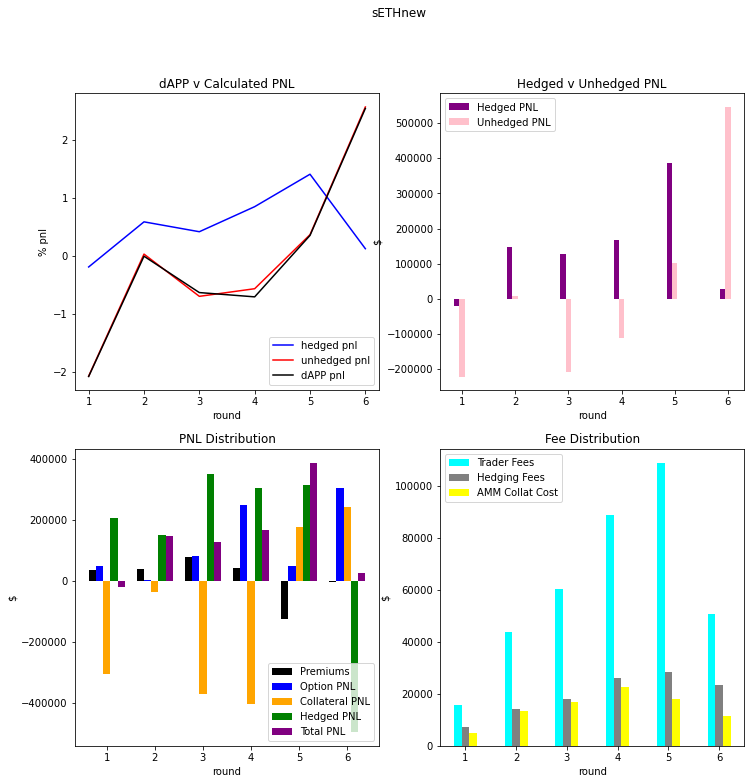

In [7]:
rounds = np.arange(len(pnls_real))+1
fig, axs = plt.subplots(2,2, figsize=(12,12))
axs[0,0].plot(rounds,data_pnl_percent_hedge, color = 'b', label = 'hedged pnl')
axs[0,0].plot(rounds,data_percent_uh, color = 'red', label = 'unhedged pnl')
axs[0,0].plot(rounds,pnls_real, color = 'black', label = 'dAPP pnl')
axs[0,0].set_xlabel('round')
axs[0,0].set_ylabel('% pnl')
axs[0,0].legend(loc="lower right")
axs[0,0].title.set_text('dAPP v Calculated PNL')

axs[0,1].bar(rounds-.1, data_pnl_hedge, width = 0.1, color = 'purple', label = 'Hedged PNL')
axs[0,1].bar(rounds, data_uh, width = 0.1, color = 'pink', label = 'Unhedged PNL')
axs[0,1].set_xlabel("round")
axs[0,1].set_ylabel("$")
axs[0,1].legend(loc="upper left")
axs[0,1].title.set_text('Hedged v Unhedged PNL')

axs[1,0].bar(rounds-.3, prems, width = 0.15, color = 'black', label = 'Premiums')
axs[1,0].bar(rounds-0.15, optionPNL, width = 0.15, color = 'blue', label = 'Option PNL')
axs[1,0].bar(rounds, collatPNL, width = 0.15, color = 'orange', label = 'Collateral PNL')
axs[1,0].bar(rounds+0.15, hedgePNL, width = 0.15, color = 'green', label = 'Hedged PNL')
axs[1,0].bar(rounds+0.3, data_pnl_hedge, width = 0.15, color = 'purple', label = 'Total PNL')
axs[1,0].set_xlabel("round")
axs[1,0].set_ylabel("$")
axs[1,0].legend(loc="lower right")
axs[1,0].title.set_text('PNL Distribution')

axs[1,1].bar(rounds-.15, edges, width = 0.15, color = 'cyan', label = 'Trader Fees')
axs[1,1].bar(rounds, hedge_fees, width = 0.15, color = 'grey', label = 'Hedging Fees')
axs[1,1].bar(rounds+.15, AMM_collat_fees, width = 0.15, color = 'yellow', label = 'AMM Collat Cost')
axs[1,1].set_xlabel("round")
axs[1,1].set_ylabel("$")
axs[1,1].legend(loc="upper left")
axs[1,1].title.set_text('Fee Distribution')

fig.suptitle('{}'.format(ASSET))



In [8]:
from DECKHedgeFunctions import *

HEDGE_FREQS = [1, 3, 6, 12, 18, 24, 36, 48]

TIME_hedge_pnl_percents = []
TIME_hedge_pnl_absolute = []
TIME_hedge_fees = []
TIME_short_fees = []
TIME_hedge_PNLs = [];

TIME_av_hedgePNL = [];
TIME_av_total_PNL = [];

fluctuation_total_PNL = {};
fluctuation_hedge_PNL = {};



HEDGE_SHIFTS = [0];

for FREQ in HEDGE_FREQS:
    print(FREQ)
    data_pnl_percent_hedge = []
    data_pnl_hedge = []
    data_uh = []
    data_percent_uh = []

    hedge_fees = [];

    short_rate_fees = [];

    prems = [];
    
    optionPNL = [];

    collatPNL = [];

    hedgePNL = [];
    
    all_av_hedgePNL = []
    all_av_data_pnl_hedge = []
    
    AMM_collat_fees = [];
    fluctuation_total_PNL['Hedge Freq {}'.format(str(FREQ))] = {};
    fluctuation_hedge_PNL['Hedge Freq {}'.format(str(FREQ))] = {};
    
    for i in range(0,6): #CHANGE HERE FOR SOL
            
    #pnl = PNL_total(updated, round_starts, i, final_spots)
        prem, opt_val, collat_pnl = PNL_total(updated, round_starts, i, final_spots)

        pnl = prem + opt_val + collat_pnl #collat_pnl includes the fees paid to buy/sell the underlying on SNX
    
        df_with_fees = fee_df(updated, i, round_starts)
    
        AMM_collat_fee = df_with_fees['AMM collat fee'].sum()
        
        mini_hedge_pnl = [];
        
        mini_abs_pnl = []
        
        fluctuation_total_PNL['Hedge Freq {}'.format(str(FREQ))]['Round {}'.format(str(i))] = {}
        fluctuation_hedge_PNL['Hedge Freq {}'.format(str(FREQ))]['Round {}'.format(str(i))] = {}
        
        for shift in HEDGE_SHIFTS:
            
        
            fees, ETHs, hedge_pnl, short_rate_fee = HedgeVisualize(FREQ, i, round_starts,starting_sUSD, df_cum,'noplot', final_spots,shift)
    
            total_pnl_hedge = pnl - np.sum(fees) - abs(short_rate_fee) + hedge_pnl
    
            percent_pnl_hedge = 100* total_pnl_hedge / starting_sUSD[i]
        
            mini_hedge_pnl.append(mini_abs_pnl)
            
            mini_abs_pnl.append(total_pnl_hedge)
            
            fluctuation_total_PNL['Hedge Freq {}'.format(str(FREQ))]['Round {}'.format(str(i))]['Shift {}'.format(str(shift))] = total_pnl_hedge
            fluctuation_hedge_PNL['Hedge Freq {}'.format(str(FREQ))]['Round {}'.format(str(i))]['Shift {}'.format(str(shift))] = hedge_pnl
        
        average_hedge_pnl = np.mean(np.array(mini_hedge_pnl))
        average_abs_pnl = np.mean(np.array(mini_abs_pnl))

        percent_pnl_UH = 100* pnl / starting_sUSD[i]
    
        total_pnl_UH = pnl
        
        data_pnl_percent_hedge.append(percent_pnl_hedge)
        data_pnl_hedge.append(total_pnl_hedge)
    
        data_uh.append(total_pnl_UH)
        data_percent_uh.append(percent_pnl_UH)
    
        prems.append(prem)
        optionPNL.append(opt_val)
        collatPNL.append(collat_pnl)
        hedgePNL.append(hedge_pnl)
        short_rate_fees.append(abs(short_rate_fee))
    
        AMM_collat_fees.append(AMM_collat_fee)
    
        hedge_fees.append(np.sum(fees) + abs(short_rate_fee))
        
        all_av_hedgePNL.append(average_hedge_pnl)
        all_av_data_pnl_hedge.append(average_abs_pnl)
        
    TIME_hedge_pnl_percents.append(data_pnl_percent_hedge)
    TIME_hedge_pnl_absolute.append(data_pnl_hedge)
    TIME_hedge_fees.append(hedge_fees)
    TIME_short_fees.append(short_rate_fees)
    TIME_hedge_PNLs.append(hedgePNL)
    TIME_av_hedgePNL.append(all_av_hedgePNL)
    TIME_av_total_PNL.append(all_av_data_pnl_hedge)
    

1
3
6
12
18
24
36
48


Text(0.5, 0.98, 'sETHnew')

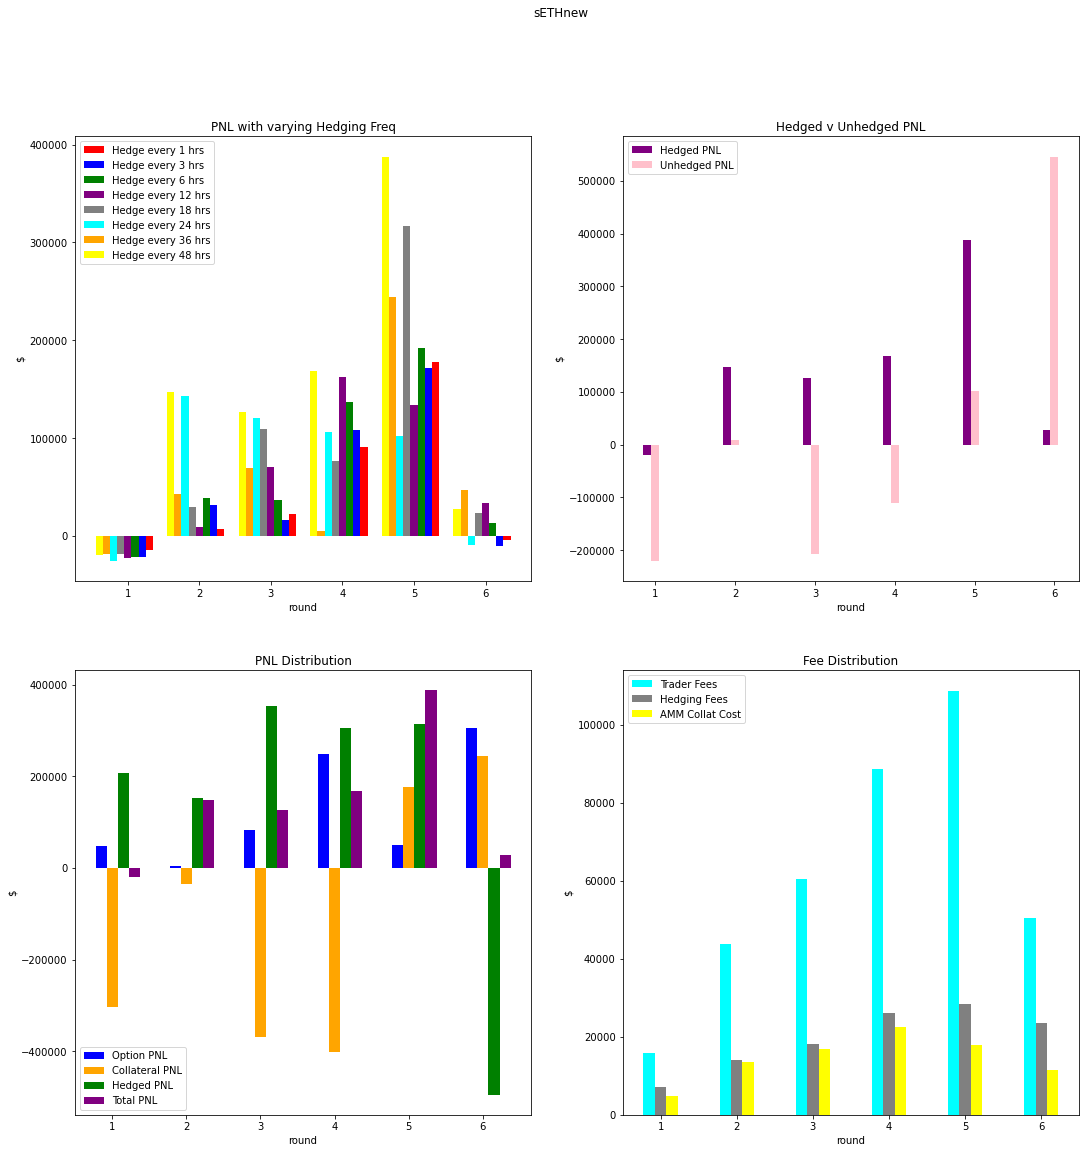

In [9]:
rounds = np.arange(6)+1 #CHANGE HERE FOR SOL
fig, axs = plt.subplots(2,2, figsize=(18,18))

cols = ['red', 'blue', 'green', 'purple', 'grey','cyan', 'orange', 'yellow'];
for i in range(0,len(TIME_hedge_pnl_absolute)):
    axs[0,0].bar(rounds+(3-i)*.1, TIME_hedge_pnl_absolute[i], width = 0.1, color = cols[i], label = 'Hedge every {} hrs'.format(HEDGE_FREQS[i]))
axs[0,0].set_xlabel("round")
axs[0,0].set_ylabel("$")
axs[0,0].legend(loc="upper left")
axs[0,0].title.set_text('PNL with varying Hedging Freq')

axs[0,1].bar(rounds-.1, data_pnl_hedge, width = 0.1, color = 'purple', label = 'Hedged PNL')
axs[0,1].bar(rounds, data_uh, width = 0.1, color = 'pink', label = 'Unhedged PNL')
axs[0,1].set_xlabel("round")
axs[0,1].set_ylabel("$")
axs[0,1].legend(loc="upper left")
axs[0,1].title.set_text('Hedged v Unhedged PNL')

#axs[0,0].bar(rounds-.3, prems, width = 0.15, color = 'black', label = 'Premiums')
axs[1,0].bar(rounds-0.15, optionPNL, width = 0.15, color = 'blue', label = 'Option PNL')
axs[1,0].bar(rounds, collatPNL, width = 0.15, color = 'orange', label = 'Collateral PNL')
axs[1,0].bar(rounds+0.15, hedgePNL, width = 0.15, color = 'green', label = 'Hedged PNL')
axs[1,0].bar(rounds+0.3, data_pnl_hedge, width = 0.15, color = 'purple', label = 'Total PNL')
axs[1,0].set_xlabel("round")
axs[1,0].set_ylabel("$")
axs[1,0].legend(loc="lower left")
axs[1,0].title.set_text('PNL Distribution')

axs[1,1].bar(rounds-.15, edges, width = 0.15, color = 'cyan', label = 'Trader Fees')
axs[1,1].bar(rounds, hedge_fees, width = 0.15, color = 'grey', label = 'Hedging Fees')
axs[1,1].bar(rounds+.15, AMM_collat_fees, width = 0.15, color = 'yellow', label = 'AMM Collat Cost')
axs[1,1].set_xlabel("round")
axs[1,1].set_ylabel("$")
axs[1,1].legend(loc="upper left")
axs[1,1].title.set_text('Fee Distribution')

fig.suptitle('{}'.format(ASSET))
